In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
sub = pd.read_csv("sample_submission.csv")
tr = pd.read_csv("train.csv").drop('ID', axis=1)
te = pd.read_csv("test.csv").drop('ID', axis=1)
va = pd.read_csv("val.csv").drop('ID', axis=1)

Text(0, 0.5, 'Frequency')

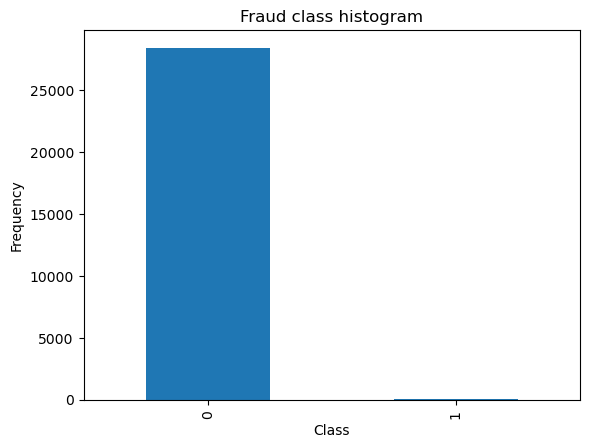

In [3]:
count_classes = pd.value_counts(va['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [4]:
vc = va['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(va), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,28432,99.89
1,1,30,0.11


## trainset에 labeling 작업

In [5]:
from sklearn.covariance import MinCovDet

In [6]:
mcd_model = MinCovDet(support_fraction=1,random_state=42)
mcd_model.fit(tr)

MinCovDet(random_state=42, support_fraction=1)

In [7]:
import torch
# 상위 N개가 이상치라고 판단

def get_pred_label(model, x, k):
  prob = abs(mcd_model.mahalanobis(x))
  prob2 = torch.tensor(prob, dtype = torch.float)
  topk_indices = torch.topk(prob2, k = k, largest = True).indices

  pred = torch.zeros(len(x), dtype = torch.long)
  pred[topk_indices] = 1
  return pred.tolist(), prob2.tolist()


val_pred, val_prob = get_pred_label(mcd_model, tr, 118)
tr["Class"] = val_pred #라벨값 지정

In [8]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

# Split to train and test and scale features
dataX = tr.drop(['Class'],axis=1)
dataY = tr.loc[:,'Class'].copy()

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)
    
featuresToScale = X_train.columns
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

In [9]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [10]:
# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [11]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

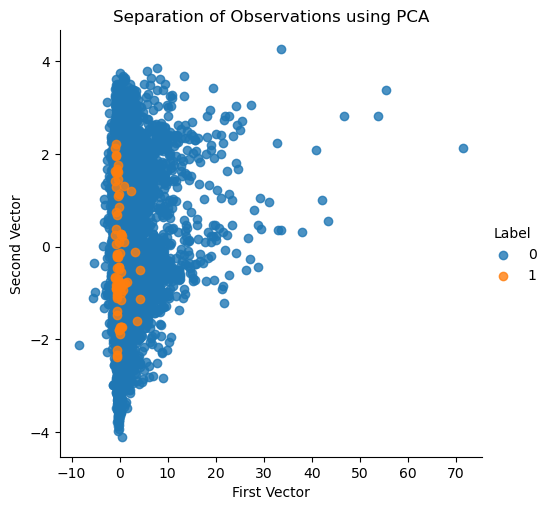

In [12]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

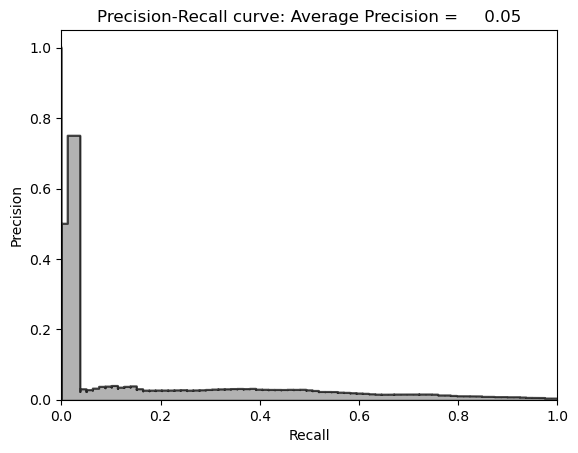

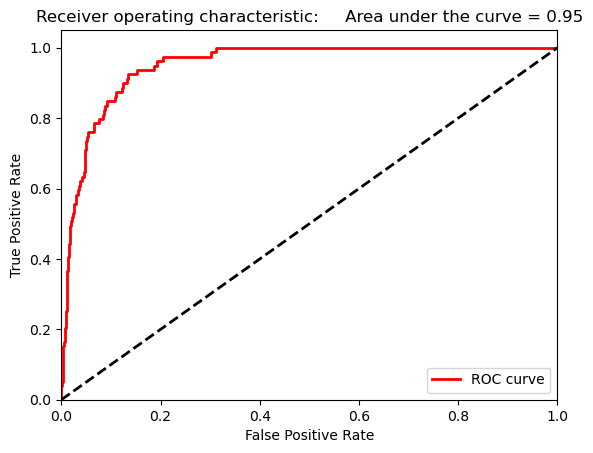

In [14]:
# View plot
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

# 음... 애매해서 EllipticEnvelope 로

In [15]:
import torch
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
val_normal, val_fraud = va['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [17]:
# 가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생 했을 것이다. -> model parameter : contamination=val_contamination(=0.001055) 적용
model = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 42)
model.fit(dataX)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=42,
                 support_fraction=0.994)

In [19]:
def get_pred_label(model, x, k):
  prob = model.score_samples(x)
  prob = torch.tensor(prob, dtype = torch.float)
  topk_indices = torch.topk(prob, k = k, largest = False).indices

  pred = torch.zeros(len(x), dtype = torch.long)
  pred[topk_indices] = 1
  return pred.tolist(), prob.tolist()

val_x = va.drop(columns=['Class']) # Input Data
val_y = va['Class'] # Label

val_pred, val_prob = get_pred_label(model, val_x, 29)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))
tn, fp, fn, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462

tp :  25 , fp :  4 , tn :  28428 , fn :  5


In [21]:
test_pred, _ = get_pred_label(model, te, 318)
print('n_fraud : ', sum(test_pred))

n_fraud :  318


In [23]:
sub['Class'] = test_pred
sub.to_csv('submit.csv', index=False)

public점수/private점수

* 0.9305289388
* 0.9054213697

/리더보드 14등 


음... 지난번 오토인코더 점수는 0.79가 최대였는데 뭐가됐던 변수 선정 안하고 다 돌리는게 점수는 훨씬 높게 나옴.. 앙상블 필요없음 안좋음...ㅠㅠㅠㅠ (현타)